In [1]:
## R code 10.1
library(rethinking)
data(chimpanzees)
d <- chimpanzees

Loading required package: rstan
Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
Loading required package: parallel
rethinking (Version 1.58)


In [2]:
## R code 10.2
m10.1 <- map(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a ,
        a ~ dnorm(0,10)
    ) ,
    data=d )
precis(m10.1)

  Mean StdDev 5.5% 94.5%
a 0.32   0.09 0.18  0.46

In [3]:
## R code 10.3
logistic( c(0.18,0.46) )

[1] 0.5448789 0.6130142

In [4]:
## R code 10.4
m10.2 <- map(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a + bp*prosoc_left ,
        a ~ dnorm(0,10) ,
        bp ~ dnorm(0,10)
    ) ,
    data=d )
m10.3 <- map(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a + (bp + bpC*condition)*prosoc_left ,
        a ~ dnorm(0,10) ,
        bp ~ dnorm(0,10) ,
        bpC ~ dnorm(0,10)
    ) ,
    data=d )

In [5]:
## R code 10.5
compare( m10.1 , m10.2 , m10.3 )

       WAIC pWAIC dWAIC weight   SE  dSE
m10.2 680.6   2.1   0.0   0.70 9.38   NA
m10.3 682.5   3.1   1.9   0.28 9.45 0.86
m10.1 687.8   0.9   7.2   0.02 7.16 6.27

In [6]:
## R code 10.6
precis(m10.3)

     Mean StdDev  5.5% 94.5%
a    0.05   0.13 -0.15  0.25
bp   0.61   0.23  0.25  0.97
bpC -0.10   0.26 -0.53  0.32

In [7]:
## R code 10.7
exp(0.61)

[1] 1.840431

In [8]:
## R code 10.8
logistic( 4 )

[1] 0.9820138

In [9]:
## R code 10.9
logistic( 4 + 0.61 )

[1] 0.9901462

In [10]:
## R code 10.10
# dummy data for predictions across treatments
d.pred <- data.frame(
    prosoc_left = c(0,1,0,1),   # right/left/right/left
    condition = c(0,0,1,1)      # control/control/partner/partner
)

# build prediction ensemble
chimp.ensemble <- ensemble( m10.1 , m10.2 , m10.3 , data=d.pred )

# summarize
pred.p <- apply( chimp.ensemble$link , 2 , mean )
pred.p.PI <- apply( chimp.ensemble$link , 2 , PI )

Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


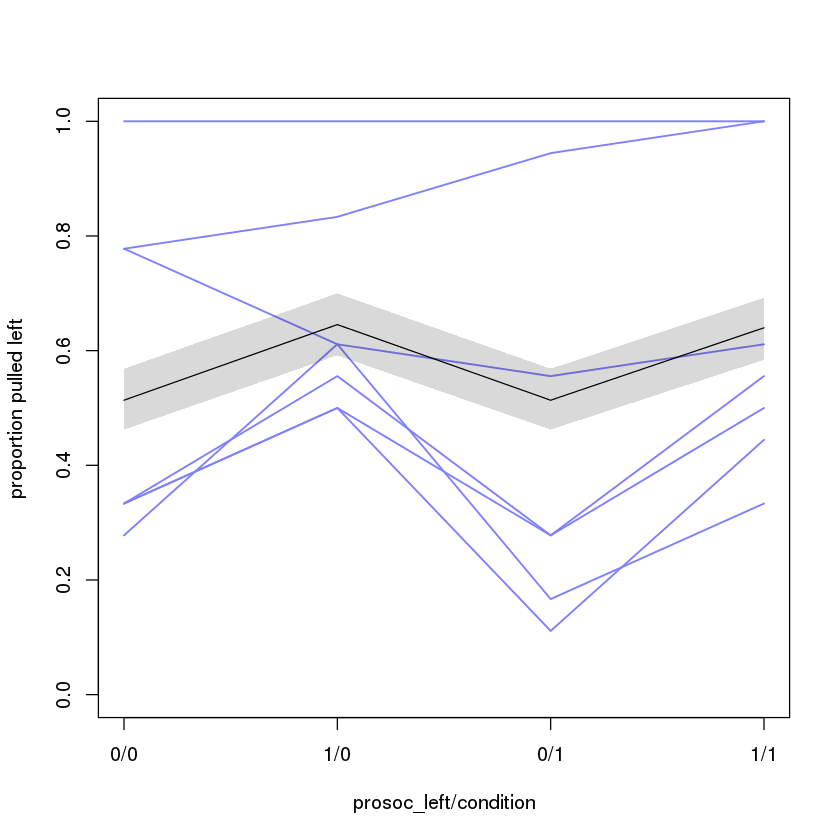

In [11]:
## R code 10.11
# empty plot frame with good axes
plot( 0 , 0 , type="n" , xlab="prosoc_left/condition" ,
    ylab="proportion pulled left" , ylim=c(0,1) , xaxt="n" ,
    xlim=c(1,4) )
axis( 1 , at=1:4 , labels=c("0/0","1/0","0/1","1/1") )

# plot raw data, one trend for each of 7 individual chimpanzees
# will use by() here; see Overthinking box for explanation
p <- by( d$pulled_left ,
    list(d$prosoc_left,d$condition,d$actor) , mean )
for ( chimp in 1:7 )
    lines( 1:4 , as.vector(p[,,chimp]) , col=rangi2 , lwd=1.5 )

# now superimpose posterior predictions
lines( 1:4 , pred.p )
shade( pred.p.PI , 1:4 )

In [12]:
## R code 10.12
# clean NAs from the data
d2 <- d
d2$recipient <- NULL

# re-use map fit to get the formula
m10.3stan <- map2stan( m10.3 , data=d2 , iter=1e4 , warmup=1000 )
precis(m10.3stan)


SAMPLING FOR MODEL 'pulled_left ~ dbinom(1, p)' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 3.28257 seconds (Warm-up)
#                24.8753 seconds (Sampling)
#                28.1579 seconds (Total)
# 

SAMPLING FOR MODEL 'pulled_left ~ dbinom(1, p)' NOW (CHAIN 1).

Chain 1, Iteration: 1 / 1 [100%]  (Sampling)# 
#  Elapsed Time: 3e-06 seconds (Warm-up)
#                0.001154 se

Computing WAIC
Constructing posterior predictions


[ 9000 / 9000 ]


     Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
a    0.05   0.13      -0.15       0.26  2623    1
bp   0.61   0.23       0.25       0.98  2687    1
bpC -0.10   0.27      -0.53       0.34  3316    1

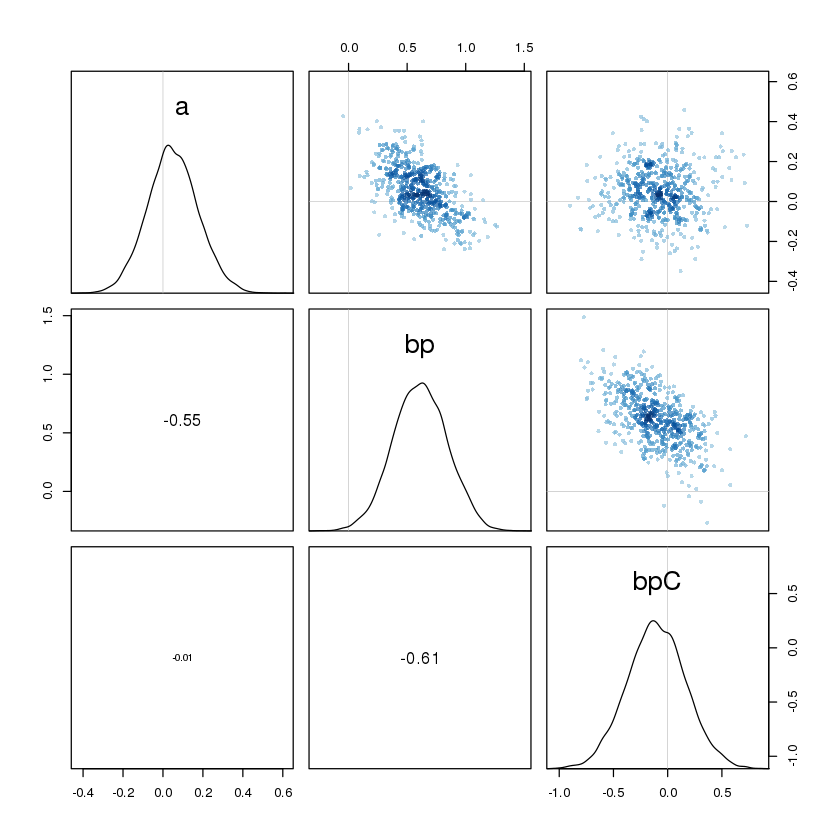

In [13]:
## R code 10.13
pairs(m10.3stan)

In [14]:
## R code 10.14
m10.4 <- map2stan(
    alist(
        pulled_left ~ dbinom( 1 , p ) ,
        logit(p) <- a[actor] + (bp + bpC*condition)*prosoc_left ,
        a[actor] ~ dnorm(0,10),
        bp ~ dnorm(0,10),
        bpC ~ dnorm(0,10)
    ) ,
    data=d2 , chains=2 , iter=2500 , warmup=500 )


SAMPLING FOR MODEL 'pulled_left ~ dbinom(1, p)' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 1, Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 1, Iteration:  500 / 2500 [ 20%]  (Warmup)
Chain 1, Iteration:  501 / 2500 [ 20%]  (Sampling)
Chain 1, Iteration:  750 / 2500 [ 30%]  (Sampling)
Chain 1, Iteration: 1000 / 2500 [ 40%]  (Sampling)
Chain 1, Iteration: 1250 / 2500 [ 50%]  (Sampling)
Chain 1, Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain 1, Iteration: 1750 / 2500 [ 70%]  (Sampling)
Chain 1, Iteration: 2000 / 2500 [ 80%]  (Sampling)
Chain 1, Iteration: 2250 / 2500 [ 90%]  (Sampling)
Chain 1, Iteration: 2500 / 2500 [100%]  (Sampling)# 
#  Elapsed Time: 3.21596 seconds (Warm-up)
#                12.7189 seconds (Sampling)
#                15.9348 seconds (Total)
# 

SAMPLING FOR MODEL 'pulled_left ~ dbinom(1, p)' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 2, Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 2, Iteration:  500 / 2500 [

Computing WAIC
Constructing posterior predictions


[ 4000 / 4000 ]


Warning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be used

In [15]:
## R code 10.15
unique( d$actor )

[1] 1 2 3 4 5 6 7

In [16]:
## R code 10.16
precis( m10.4 , depth=2 )

Warning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be used

      Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
a[1] -0.74   0.27      -1.18      -0.32  2525    1
a[2] 10.91   5.36       3.43      18.69  1332    1
a[3] -1.06   0.29      -1.51      -0.59  1892    1
a[4] -1.05   0.29      -1.48      -0.57  2535    1
a[5] -0.74   0.28      -1.18      -0.31  2234    1
a[6]  0.21   0.27      -0.20       0.66  2443    1
a[7]  1.82   0.40       1.15       2.41  2627    1
bp    0.83   0.27       0.40       1.26  1615    1
bpC  -0.12   0.30      -0.62       0.32  1957    1

In [17]:
## R code 10.17
post <- extract.samples( m10.4 )
str( post )

List of 3
 $ a  : num [1:4000, 1:7] -0.787 -0.33 -0.956 -0.799 -0.346 ...
 $ bp : num [1:4000(1d)] 1.081 0.492 0.742 0.934 0.753 ...
 $ bpC: num [1:4000(1d)] -0.4186 0.1361 -0.4626 -0.4152 -0.0723 ...


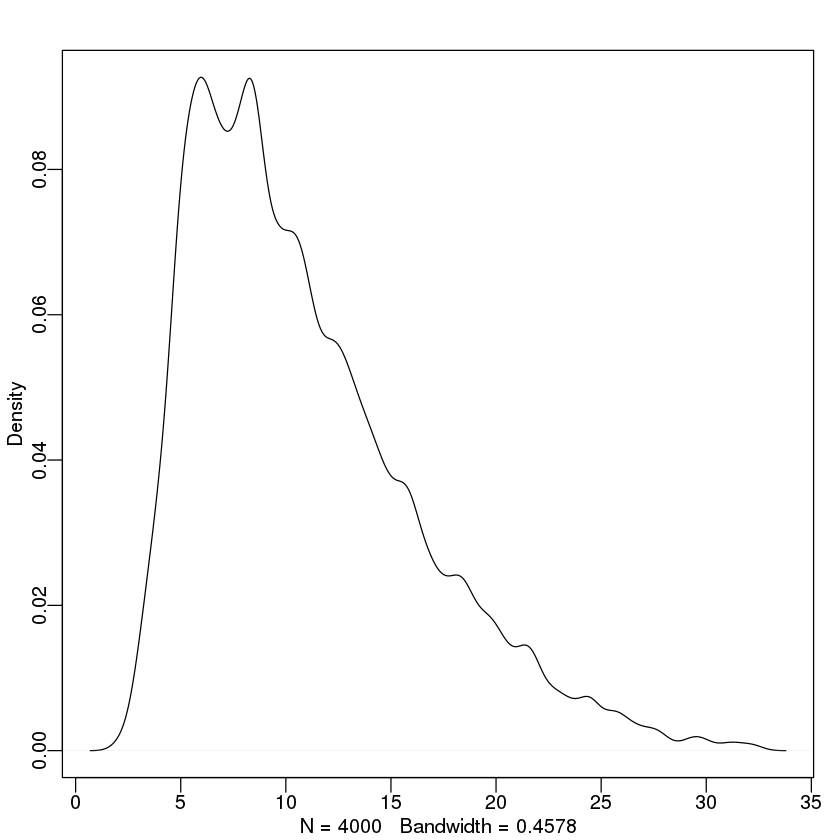

In [18]:
## R code 10.18
dens( post$a[,2] )

[ 1000 / 1000 ]


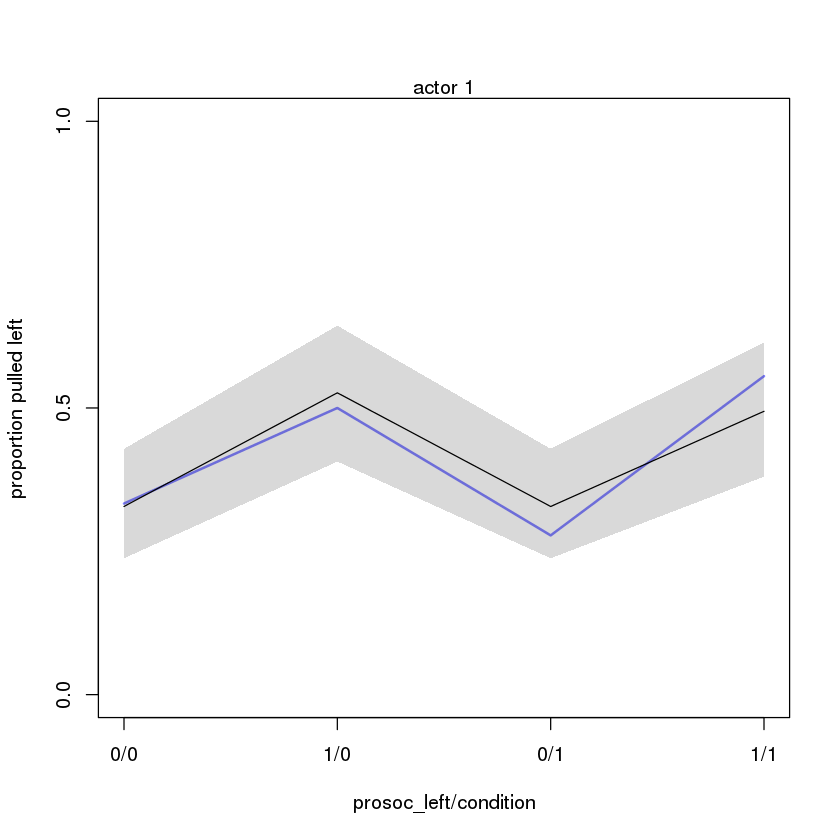

In [19]:
## R code 10.19
chimp <- 1
d.pred <- list(
    pulled_left = rep( 0 , 4 ), # empty outcome
    prosoc_left = c(0,1,0,1),   # right/left/right/left
    condition = c(0,0,1,1),     # control/control/partner/partner
    actor = rep(chimp,4)
)
link.m10.4 <- link( m10.4 , data=d.pred )
pred.p <- apply( link.m10.4 , 2 , mean )
pred.p.PI <- apply( link.m10.4 , 2 , PI )

plot( 0 , 0 , type="n" , xlab="prosoc_left/condition" ,
    ylab="proportion pulled left" , ylim=c(0,1) , xaxt="n" ,
    xlim=c(1,4) , yaxp=c(0,1,2) )
axis( 1 , at=1:4 , labels=c("0/0","1/0","0/1","1/1") )
mtext( paste( "actor" , chimp ) )

p <- by( d$pulled_left ,
    list(d$prosoc_left,d$condition,d$actor) , mean )
lines( 1:4 , as.vector(p[,,chimp]) , col=rangi2 , lwd=2 )

lines( 1:4 , pred.p )
shade( pred.p.PI , 1:4 )

In [20]:
## R code 10.20
data(chimpanzees)
d <- chimpanzees
d.aggregated <- aggregate( d$pulled_left ,
    list(prosoc_left=d$prosoc_left,condition=d$condition,actor=d$actor) ,
    sum )

In [21]:
## R code 10.21
m10.5 <- map(
    alist(
        x ~ dbinom( 18 , p ) ,
        logit(p) <- a + (bp + bpC*condition)*prosoc_left ,
        a ~ dnorm(0,10) ,
        bp ~ dnorm(0,10) ,
        bpC ~ dnorm(0,10)
    ) ,
    data=d.aggregated )

In [22]:
## R code 10.22
library(rethinking)
data(UCBadmit)
d <- UCBadmit

In [23]:
## R code 10.23
d$male <- ifelse( d$applicant.gender=="male" , 1 , 0 )
m10.6 <- map(
    alist(
         admit ~ dbinom( applications , p ) ,
         logit(p) <- a + bm*male ,
         a ~ dnorm(0,10) ,
         bm ~ dnorm(0,10)
    ) ,
    data=d )
m10.7 <- map(
    alist(
         admit ~ dbinom( applications , p ) ,
         logit(p) <- a ,
         a ~ dnorm(0,10)
    ) ,
    data=d )

In [24]:
## R code 10.24
compare( m10.6 , m10.7 )

        WAIC pWAIC dWAIC weight    SE   dSE
m10.6 5954.9     2   0.0      1 34.96    NA
m10.7 6046.3     1  91.5      0 29.89 19.09

In [25]:
## R code 10.25
precis(m10.6)

    Mean StdDev  5.5% 94.5%
a  -0.83   0.05 -0.91 -0.75
bm  0.61   0.06  0.51  0.71

In [26]:
## R code 10.26
post <- extract.samples( m10.6 )
p.admit.male <- logistic( post$a + post$bm )
p.admit.female <- logistic( post$a )
diff.admit <- p.admit.male - p.admit.female
quantile( diff.admit , c(0.025,0.5,0.975) )

2.5%       50%     97.5% 
0.1132178 0.1414229 0.1693497

[ 10000 / 10000 ]
[ 10000 / 10000 ]


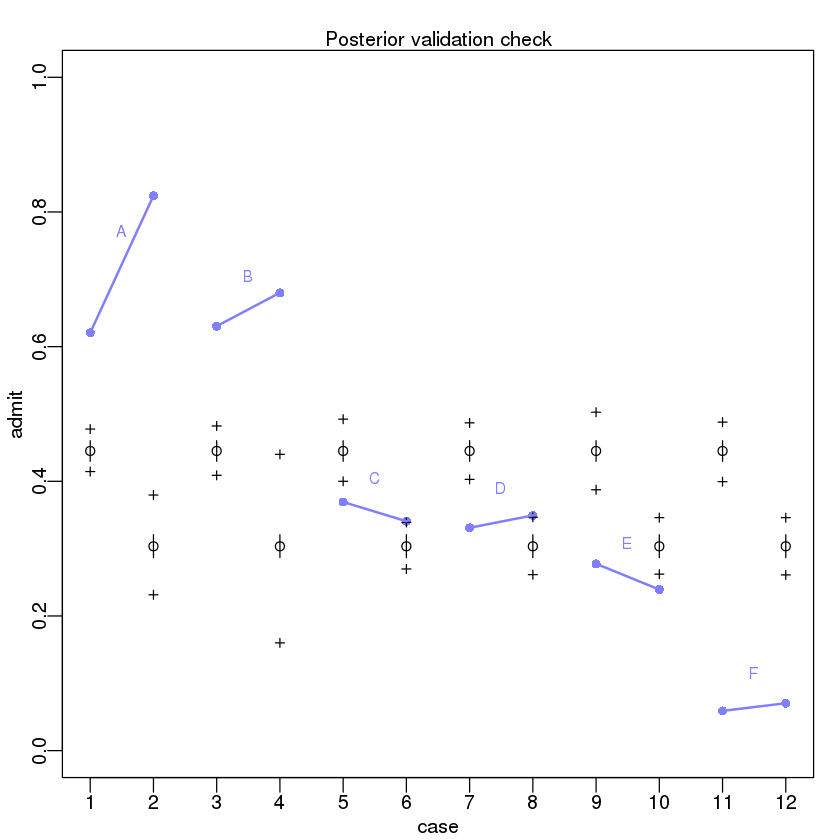

In [27]:
## R code 10.27
postcheck( m10.6 , n=1e4 )
# draw lines connecting points from same dept
for ( i in 1:6 ) {
    x <- 1 + 2*(i-1)
    y1 <- d$admit[x]/d$applications[x]
    y2 <- d$admit[x+1]/d$applications[x+1]
    lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
    text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [28]:
## R code 10.28
# make index
d$dept_id <- coerce_index( d$dept )

# model with unique intercept for each dept
m10.8 <- map(
    alist(
        admit ~ dbinom( applications , p ) ,
        logit(p) <- a[dept_id] ,
        a[dept_id] ~ dnorm(0,10)
    ) , data=d )

# model with male difference as well
m10.9 <- map(
    alist(
        admit ~ dbinom( applications , p ) ,
        logit(p) <- a[dept_id] + bm*male ,
        a[dept_id] ~ dnorm(0,10) ,
        bm ~ dnorm(0,10)
    ) , data=d )

In [29]:
## R code 10.29
compare( m10.6 , m10.7 , m10.8 , m10.9 )

        WAIC pWAIC dWAIC weight    SE   dSE
m10.8 5201.2   6.1   0.0   0.59 57.05    NA
m10.9 5201.9   7.2   0.7   0.41 57.19  2.33
m10.6 5955.2   2.1 754.0   0.00 35.02 48.50
m10.7 6046.3   1.0 845.2   0.00 29.98 52.34

In [30]:
## R code 10.30
precis( m10.9 , depth=2 )

      Mean StdDev  5.5% 94.5%
a[1]  0.68   0.10  0.52  0.84
a[2]  0.64   0.12  0.45  0.82
a[3] -0.58   0.07 -0.70 -0.46
a[4] -0.61   0.09 -0.75 -0.48
a[5] -1.06   0.10 -1.22 -0.90
a[6] -2.62   0.16 -2.88 -2.37
bm   -0.10   0.08 -0.23  0.03

In [31]:
## R code 10.31
m10.9stan <- map2stan( m10.9 , chains=2 , iter=2500 , warmup=500 )
precis(m10.9stan,depth=2)

Will attempt to remove dots internally.
Warning message:
In FUN(X[[i]], ...): data with name dept is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name applicant_gender is not numeric and not used


SAMPLING FOR MODEL 'admit ~ dbinom(applications, p)' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 1, Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 1, Iteration:  500 / 2500 [ 20%]  (Warmup)
Chain 1, Iteration:  501 / 2500 [ 20%]  (Sampling)
Chain 1, Iteration:  750 / 2500 [ 30%]  (Sampling)
Chain 1, Iteration: 1000 / 2500 [ 40%]  (Sampling)
Chain 1, Iteration: 1250 / 2500 [ 50%]  (Sampling)
Chain 1, Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain 1, Iteration: 1750 / 2500 [ 70%]  (Sampling)
Chain 1, Iteration: 2000 / 2500 [ 80%]  (Sampling)
Chain 1, Iteration: 2250 / 2500 [ 90%]  (Sampling)
Chain 1, Iteration: 2500 / 2500 [100%]  (Sampling)# 
#  Elapsed Time: 0.214844 seconds (Warm-up)
#                0.649975 seconds (Sampling)
#                0.864819 seconds (Total)
# 

SAMPLING FOR MODEL 'admit ~ dbinom(applications, p)' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 2, Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 2, Iteration: 

Warning message:
In FUN(X[[i]], ...): data with name dept is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name applicant_gender is not numeric and not used


SAMPLING FOR MODEL 'admit ~ dbinom(applications, p)' NOW (CHAIN 1).

Chain 1, Iteration: 1 / 1 [100%]  (Sampling)# 
#  Elapsed Time: 3e-06 seconds (Warm-up)
#                0.000142 seconds (Sampling)
#                0.000145 seconds (Total)
# 


Computing WAIC
Constructing posterior predictions


[ 4000 / 4000 ]


Aggregated binomial counts detected. Splitting to 0/1 outcome for WAIC calculation.
Warning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be usedWarning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be used

      Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
a[1]  0.68   0.10       0.54       0.85  1629    1
a[2]  0.64   0.12       0.45       0.82  1680    1
a[3] -0.58   0.07      -0.70      -0.47  1466    1
a[4] -0.61   0.09      -0.75      -0.48  2269    1
a[5] -1.06   0.10      -1.22      -0.90  2814    1
a[6] -2.63   0.16      -2.88      -2.38  3062    1
bm   -0.10   0.08      -0.23       0.03  1374    1

In [32]:
## R code 10.32
m10.7glm <- glm( cbind(admit,reject) ~ 1 , data=d , family=binomial )
m10.6glm <- glm( cbind(admit,reject) ~ male , data=d , family=binomial )
m10.8glm <- glm( cbind(admit,reject) ~ dept , data=d , family=binomial )
m10.9glm <- glm( cbind(admit,reject) ~ male + dept , data=d ,
    family=binomial )

In [33]:
## R code 10.33
data(chimpanzees)
m10.4glm <- glm(
    pulled_left ~ as.factor(actor) + prosoc_left * condition - condition ,
    data=chimpanzees , family=binomial )

In [34]:
## R code 10.34
glimmer( pulled_left ~ prosoc_left * condition - condition ,
    data=chimpanzees , family=binomial )

alist(
    pulled_left ~ dbinom( 1 , p ),
    logit(p) <- Intercept +
        b_prosoc_left*prosoc_left +
        b_prosoc_left_X_condition*prosoc_left_X_condition,
    Intercept ~ dnorm(0,10),
    b_prosoc_left ~ dnorm(0,10),
    b_prosoc_left_X_condition ~ dnorm(0,10)
)


In [35]:
## R code 10.35
# outcome and predictor almost perfectly associated
y <- c( rep(0,10) , rep(1,10) )
x <- c( rep(-1,9) , rep(1,11) )
# fit binomial GLM
m.bad <- glm( y ~ x , data=list(y=y,x=x) , family=binomial )
precis(m.bad)

             Mean  StdDev     5.5%   94.5%
(Intercept) -9.13 2955.06 -4731.89 4713.63
x           11.43 2955.06 -4711.33 4734.19

In [36]:
## R code 10.36
m.good <- map(
    alist(
        y ~ dbinom( 1 , p ),
        logit(p) <- a + b*x,
        c(a,b) ~ dnorm(0,10)
    ) , data=list(y=y,x=x) )
precis(m.good)

   Mean StdDev  5.5% 94.5%
a -1.73   2.77 -6.15  2.70
b  4.02   2.77 -0.41  8.45


SAMPLING FOR MODEL 'y ~ dbinom(1, p)' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)# 
#  Elapsed Time: 0.364267 seconds (Warm-up)
#                0.392278 seconds (Sampling)
#                0.756545 seconds (Total)
# 

SAMPLING FOR MODEL 'y ~ dbinom(1, p)' NOW (CHAIN 1).

Chain 1, Iteration: 1 / 1 [100%]  (Sampling)# 
#  Elapsed Time: 3e-06 seconds (Warm-up)
#                0.000134 seconds (Sampling)
#                0.00

Computing WAIC
Constructing posterior predictions


[ 1000 / 1000 ]


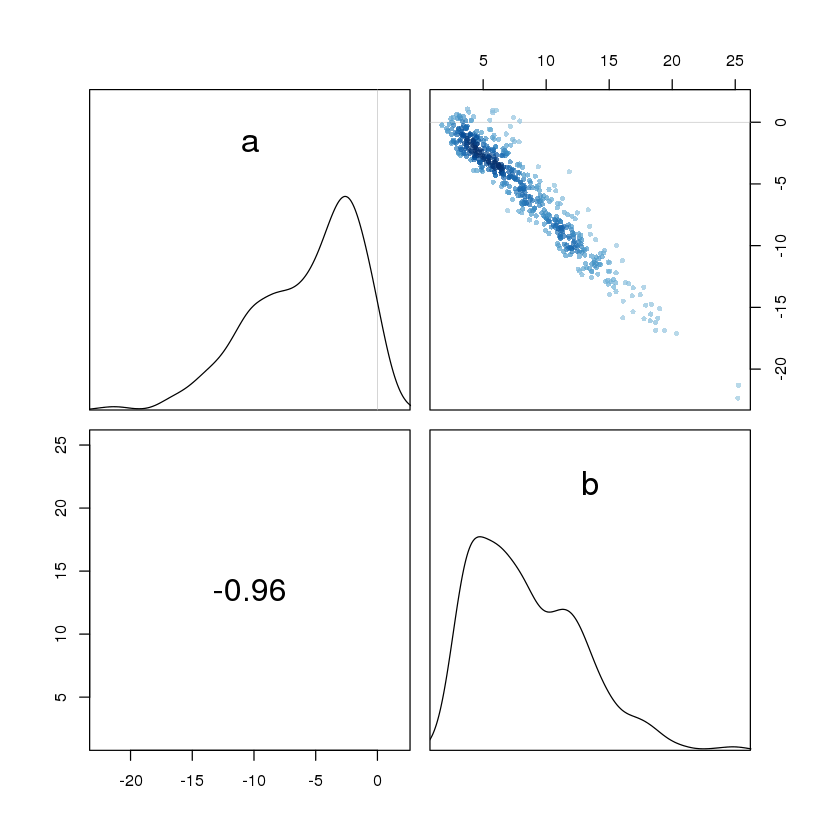

In [37]:
## R code 10.37
m.good.stan <- map2stan( m.good )
pairs(m.good.stan)

In [38]:
## R code 10.38
y <- rbinom(1e5,1000,1/1000)
c( mean(y) , var(y) )

[1] 1.0008100 0.9962393

In [39]:
## R code 10.39
library(rethinking)
data(Kline)
d <- Kline
d

,culture,population,contact,total_tools,mean_TU
1,Malekula,1100,low,13,3.2
2,Tikopia,1500,low,22,4.7
3,Santa Cruz,3600,low,24,4
4,Yap,4791,high,43,5
5,Lau Fiji,7400,high,33,5
6,Trobriand,8000,high,19,4
7,Chuuk,9200,high,40,3.8
8,Manus,13000,low,28,6.6
9,Tonga,17500,high,55,5.4
10,Hawaii,275000,low,71,6.6


In [40]:
## R code 10.40
d$log_pop <- log(d$population)
d$contact_high <- ifelse( d$contact=="high" , 1 , 0 )

In [41]:
## R code 10.41
m10.10 <- map(
    alist(
        total_tools ~ dpois( lambda ),
        log(lambda) <- a + bp*log_pop +
            bc*contact_high + bpc*contact_high*log_pop,
        a ~ dnorm(0,100),
        c(bp,bc,bpc) ~ dnorm(0,1)
    ),
    data=d )

     Mean StdDev  5.5% 94.5%     a    bp    bc   bpc
a    0.94   0.36  0.37  1.52  1.00 -0.98 -0.13  0.07
bp   0.26   0.03  0.21  0.32 -0.98  1.00  0.12 -0.08
bc  -0.09   0.84 -1.43  1.25 -0.13  0.12  1.00 -0.99
bpc  0.04   0.09 -0.10  0.19  0.07 -0.08 -0.99  1.00

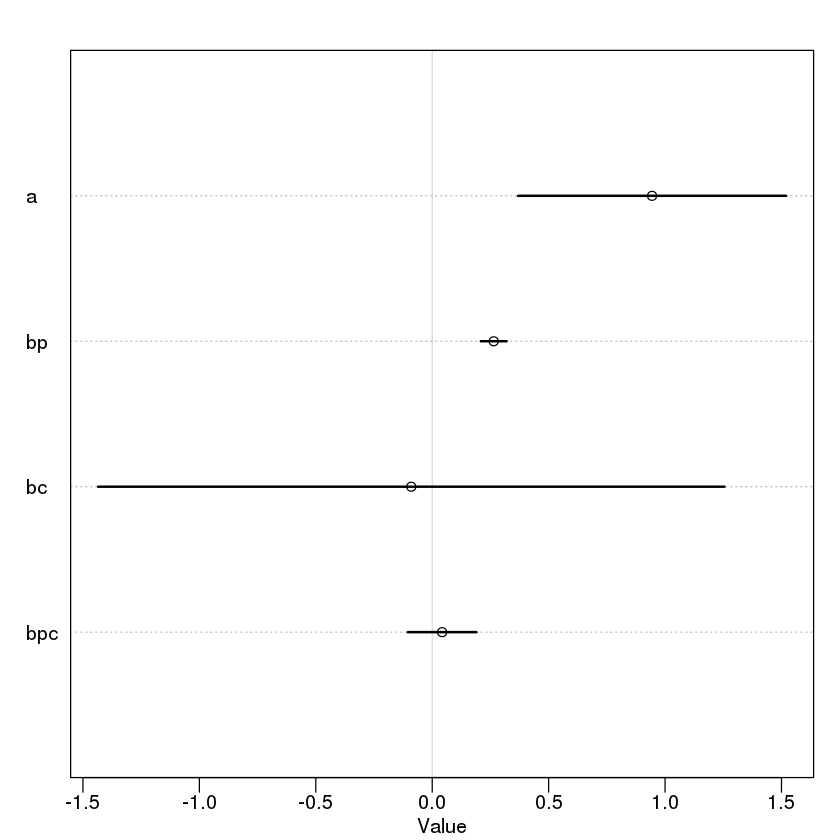

In [42]:
## R code 10.42
precis(m10.10,corr=TRUE)
plot(precis(m10.10))

In [43]:
## R code 10.43
post <- extract.samples(m10.10)
lambda_high <- exp( post$a + post$bc + (post$bp + post$bpc)*8 )
lambda_low <- exp( post$a + post$bp*8 )

In [44]:
## R code 10.44
diff <- lambda_high - lambda_low
sum(diff > 0)/length(diff)

[1] 0.956

In [45]:
## R code 10.45
# no interaction
m10.11 <- map(
    alist(
        total_tools ~ dpois( lambda ),
        log(lambda) <- a + bp*log_pop + bc*contact_high,
        a ~ dnorm(0,100),
        c(bp,bc) ~ dnorm( 0 , 1 )
    ), data=d )

In [46]:
## R code 10.46
# no contact rate
m10.12 <- map(
    alist(
        total_tools ~ dpois( lambda ),
        log(lambda) <- a + bp*log_pop,
        a ~ dnorm(0,100),
        bp ~ dnorm( 0 , 1 )
    ), data=d )

# no log-population
m10.13 <- map(
    alist(
        total_tools ~ dpois( lambda ),
        log(lambda) <- a + bc*contact_high,
        a ~ dnorm(0,100),
        bc ~ dnorm( 0 , 1 )
    ), data=d )

        WAIC pWAIC dWAIC weight    SE   dSE
m10.11  79.0   4.2   0.0   0.62 11.21    NA
m10.10  80.2   4.9   1.2   0.34 11.35  1.26
m10.12  84.5   3.8   5.5   0.04  8.88  8.41
m10.14 141.2   8.1  62.2   0.00 31.35 34.23
m10.13 149.9  16.9  70.9   0.00 44.05 46.08

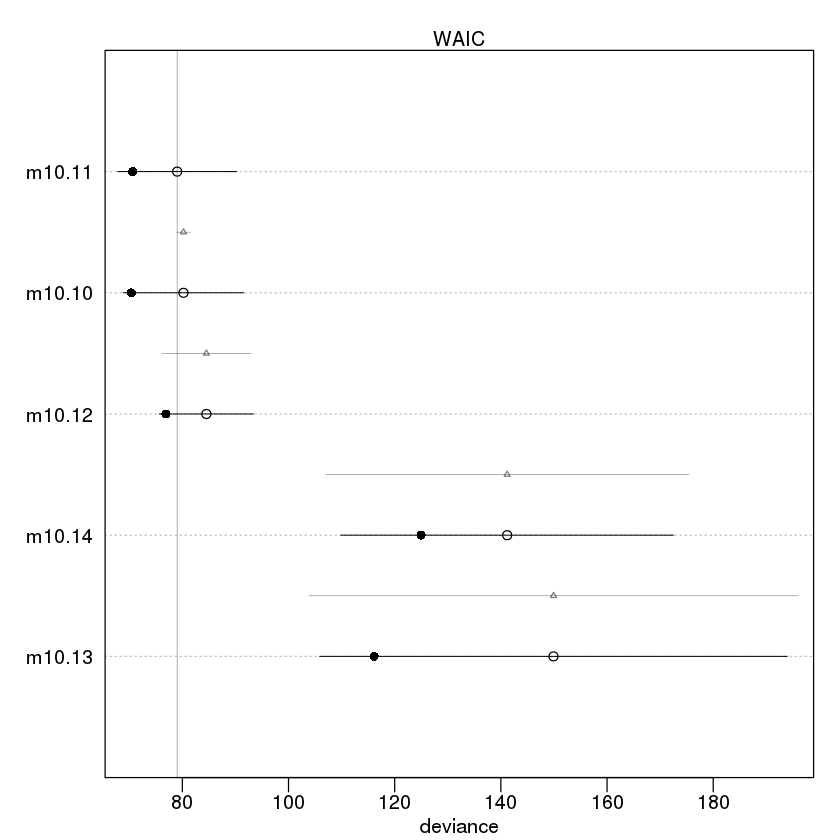

In [47]:
## R code 10.47
# intercept only
m10.14 <- map(
    alist(
        total_tools ~ dpois( lambda ),
        log(lambda) <- a,
        a ~ dnorm(0,100)
    ), data=d )

# compare all using WAIC
# adding n=1e4 for more stable WAIC estimates
# will also plot the comparison
( islands.compare <- compare(m10.10,m10.11,m10.12,m10.13,m10.14,n=1e4) )
plot(islands.compare)

Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


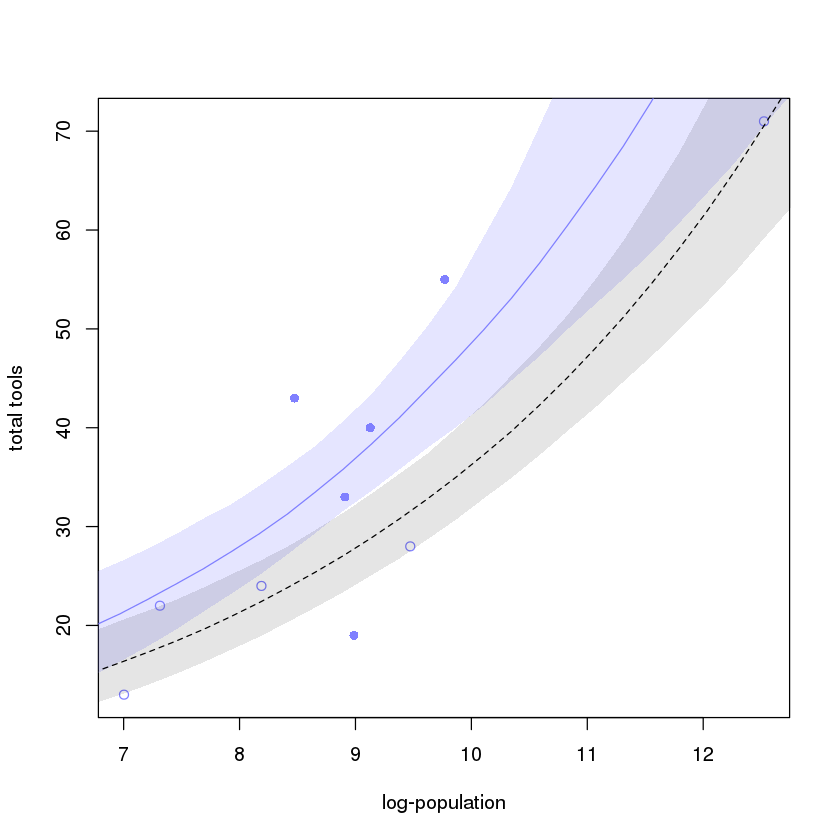

In [48]:
## R code 10.48
# make plot of raw data to begin
# point character (pch) indicates contact rate
pch <- ifelse( d$contact_high==1 , 16 , 1 )
plot( d$log_pop , d$total_tools , col=rangi2 , pch=pch ,
    xlab="log-population" , ylab="total tools" )

# sequence of log-population sizes to compute over
log_pop.seq <- seq( from=6 , to=13 , length.out=30 )

# compute trend for high contact islands
d.pred <- data.frame(
    log_pop = log_pop.seq,
    contact_high = 1
)
lambda.pred.h <- ensemble( m10.10 , m10.11 , m10.12 , data=d.pred )
lambda.med <- apply( lambda.pred.h$link , 2 , median )
lambda.PI <- apply( lambda.pred.h$link , 2 , PI )

# plot predicted trend for high contact islands
lines( log_pop.seq , lambda.med , col=rangi2 )
shade( lambda.PI , log_pop.seq , col=col.alpha(rangi2,0.2) )

# compute trend for low contact islands
d.pred <- data.frame(
    log_pop = log_pop.seq,
    contact_high = 0
)
lambda.pred.l <- ensemble( m10.10 , m10.11 , m10.12 , data=d.pred )
lambda.med <- apply( lambda.pred.l$link , 2 , median )
lambda.PI <- apply( lambda.pred.l$link , 2 , PI )

# plot again
lines( log_pop.seq , lambda.med , lty=2 )
shade( lambda.PI , log_pop.seq , col=col.alpha("black",0.1) )

In [49]:
## R code 10.49
m10.10stan <- map2stan( m10.10 , iter=3000 , warmup=1000 , chains=4 )
precis(m10.10stan)

Warning message:
In FUN(X[[i]], ...): data with name culture is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name contact is not numeric and not used


SAMPLING FOR MODEL 'total_tools ~ dpois(lambda)' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 1, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 1, Iteration:  600 / 3000 [ 20%]  (Warmup)
Chain 1, Iteration:  900 / 3000 [ 30%]  (Warmup)
Chain 1, Iteration: 1001 / 3000 [ 33%]  (Sampling)
Chain 1, Iteration: 1300 / 3000 [ 43%]  (Sampling)
Chain 1, Iteration: 1600 / 3000 [ 53%]  (Sampling)
Chain 1, Iteration: 1900 / 3000 [ 63%]  (Sampling)
Chain 1, Iteration: 2200 / 3000 [ 73%]  (Sampling)
Chain 1, Iteration: 2500 / 3000 [ 83%]  (Sampling)
Chain 1, Iteration: 2800 / 3000 [ 93%]  (Sampling)
Chain 1, Iteration: 3000 / 3000 [100%]  (Sampling)# 
#  Elapsed Time: 1.32813 seconds (Warm-up)
#                2.47744 seconds (Sampling)
#                3.80558 seconds (Total)
# 

SAMPLING FOR MODEL 'total_tools ~ dpois(lambda)' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 2, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 2, Iteration:  600 / 3000 [

Warning message:
In FUN(X[[i]], ...): data with name culture is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name contact is not numeric and not used


SAMPLING FOR MODEL 'total_tools ~ dpois(lambda)' NOW (CHAIN 1).

Chain 1, Iteration: 1 / 1 [100%]  (Sampling)# 
#  Elapsed Time: 3e-06 seconds (Warm-up)
#                0.000112 seconds (Sampling)
#                0.000115 seconds (Total)
# 


Computing WAIC
Constructing posterior predictions


[ 8000 / 8000 ]


Warning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be usedWarning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be used

     Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
a    0.92   0.36       0.37       1.51  1639    1
bp   0.27   0.03       0.21       0.32  1613    1
bc  -0.10   0.85      -1.46       1.20  2069    1
bpc  0.04   0.09      -0.10       0.19  2080    1

In [50]:
## R code 10.50
# construct centered predictor
d$log_pop_c <- d$log_pop - mean(d$log_pop)

# re-estimate
m10.10stan.c <- map2stan(
    alist(
        total_tools ~ dpois( lambda ) ,
        log(lambda) <- a + bp*log_pop_c + bc*contact_high +
            bcp*log_pop_c*contact_high ,
        a ~ dnorm(0,10) ,
        bp ~ dnorm(0,1) ,
        bc ~ dnorm(0,1) ,
        bcp ~ dnorm(0,1)
    ) ,
    data=d , iter=3000 , warmup=1000 , chains=4 )
precis(m10.10stan.c)

Warning message:
In FUN(X[[i]], ...): data with name culture is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name contact is not numeric and not used


SAMPLING FOR MODEL 'total_tools ~ dpois(lambda)' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 1, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 1, Iteration:  600 / 3000 [ 20%]  (Warmup)
Chain 1, Iteration:  900 / 3000 [ 30%]  (Warmup)
Chain 1, Iteration: 1001 / 3000 [ 33%]  (Sampling)
Chain 1, Iteration: 1300 / 3000 [ 43%]  (Sampling)
Chain 1, Iteration: 1600 / 3000 [ 53%]  (Sampling)
Chain 1, Iteration: 1900 / 3000 [ 63%]  (Sampling)
Chain 1, Iteration: 2200 / 3000 [ 73%]  (Sampling)
Chain 1, Iteration: 2500 / 3000 [ 83%]  (Sampling)
Chain 1, Iteration: 2800 / 3000 [ 93%]  (Sampling)
Chain 1, Iteration: 3000 / 3000 [100%]  (Sampling)# 
#  Elapsed Time: 0.259243 seconds (Warm-up)
#                0.448475 seconds (Sampling)
#                0.707718 seconds (Total)
# 

SAMPLING FOR MODEL 'total_tools ~ dpois(lambda)' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 2, Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 2, Iteration:  600 / 300

Warning message:
In FUN(X[[i]], ...): data with name culture is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name contact is not numeric and not used


SAMPLING FOR MODEL 'total_tools ~ dpois(lambda)' NOW (CHAIN 1).

Chain 1, Iteration: 1 / 1 [100%]  (Sampling)# 
#  Elapsed Time: 3e-06 seconds (Warm-up)
#                0.000145 seconds (Sampling)
#                0.000148 seconds (Total)
# 


Computing WAIC
Constructing posterior predictions


[ 8000 / 8000 ]


Warning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be usedWarning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be used

    Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
a   3.31   0.09       3.17       3.46  2752    1
bp  0.26   0.04       0.20       0.32  3428    1
bc  0.28   0.12       0.10       0.46  2738    1
bcp 0.07   0.17      -0.20       0.34  4320    1

In [51]:
## R code 10.51
num_days <- 30
y <- rpois( num_days , 1.5 )

In [52]:
## R code 10.52
num_weeks <- 4
y_new <- rpois( num_weeks , 0.5*7 )

In [53]:
## R code 10.53
y_all <- c( y , y_new )
exposure <- c( rep(1,30) , rep(7,4) )
monastery <- c( rep(0,30) , rep(1,4) )
d <- data.frame( y=y_all , days=exposure , monastery=monastery )

In [54]:
## R code 10.54
# compute the offset
d$log_days <- log( d$days )

# fit the model
m10.15 <- map(
    alist(
        y ~ dpois( lambda ),
        log(lambda) <- log_days + a + b*monastery,
        a ~ dnorm(0,100),
        b ~ dnorm(0,1)
    ),
    data=d )

In [55]:
## R code 10.55
post <- extract.samples( m10.15 )
lambda_old <- exp( post$a )
lambda_new <- exp( post$a + post$b )
precis( data.frame( lambda_old , lambda_new ) )

           Mean StdDev |0.89 0.89|
lambda_old 1.28   0.20  0.97  1.60
lambda_new 0.51   0.14  0.31  0.73

In [56]:
## R code 10.56
# simulate career choices among 500 individuals
N <- 500             # number of individuals
income <- 1:3        # expected income of each career
score <- 0.5*income  # scores for each career, based on income
# next line converts scores to probabilities
p <- softmax(score[1],score[2],score[3])

# now simulate choice
# outcome career holds event type values, not counts
career <- rep(NA,N)  # empty vector of choices for each individual
# sample chosen career for each individual
for ( i in 1:N ) career[i] <- sample( 1:3 , size=1 , prob=p )

In [57]:
## R code 10.57
# fit the model, using dcategorical and softmax link
m10.16 <- map(
    alist(
        career ~ dcategorical( softmax(0,s2,s3) ),
        s2 <- b*2,    # linear model for event type 2
        s3 <- b*3,    # linear model for event type 3
        b ~ dnorm(0,5)
    ) ,
    data=list(career=career) )

In [58]:
## R code 10.58
N <- 100
# simulate family incomes for each individual
family_income <- runif(N)
# assign a unique coefficient for each type of event
b <- (1:-1)
career <- rep(NA,N)  # empty vector of choices for each individual
for ( i in 1:N ) {
    score <- 0.5*(1:3) + b*family_income[i]
    p <- softmax(score[1],score[2],score[3])
    career[i] <- sample( 1:3 , size=1 , prob=p )
}

m10.17 <- map(
    alist(
        career ~ dcategorical( softmax(0,s2,s3) ),
        s2 <- a2 + b2*family_income,
        s3 <- a3 + b3*family_income,
        c(a2,a3,b2,b3) ~ dnorm(0,5)
    ) ,
    data=list(career=career,family_income=family_income) )

In [59]:
## R code 10.59
library(rethinking)
data(UCBadmit)
d <- UCBadmit

In [60]:
## R code 10.60
# binomial model of overall admission probability
m_binom <- map(
    alist(
        admit ~ dbinom(applications,p),
        logit(p) <- a,
        a ~ dnorm(0,100)
    ),
    data=d )

# Poisson model of overall admission rate and rejection rate
d$rej <- d$reject # 'reject' is a reserved word
m_pois <- map2stan(
    alist(
        admit ~ dpois(lambda1),
        rej ~ dpois(lambda2),
        log(lambda1) <- a1,
        log(lambda2) <- a2,
        c(a1,a2) ~ dnorm(0,100)
    ),
    data=d , chains=3 , cores=3 )

Will attempt to remove dots internally.
Warning message:
In FUN(X[[i]], ...): data with name dept is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name applicant_gender is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name dept is not numeric and not usedWarning message:
In FUN(X[[i]], ...): data with name applicant_gender is not numeric and not used


SAMPLING FOR MODEL 'admit ~ dpois(lambda1)' NOW (CHAIN 1).

Chain 1, Iteration: 1 / 1 [100%]  (Sampling)# 
#  Elapsed Time: 2e-06 seconds (Warm-up)
#                0.000109 seconds (Sampling)
#                0.000111 seconds (Total)
# 


Computing WAIC
Constructing posterior predictions


[ 3000 / 3000 ]


Warning message:
In if (object@sim$warmup2 == 0) warning("warmup samples not saved"): the condition has length > 1 and only the first element will be used

In [61]:
## R code 10.61
logistic(coef(m_binom))

a 
0.3877807

In [62]:
## R code 10.62
k <- as.numeric(coef(m_pois))
exp(k[1])/(exp(k[1])+exp(k[2]))

[1] 0.3878577

In [63]:
## R code 10.63
# simulate
N <- 100
x <- runif(N)
y <- rgeom( N , prob=logistic( -1 + 2*x ) )

# estimate
m10.18 <- map(
    alist(
        y ~ dgeom( p ),
        logit(p) <- a + b*x,
        a ~ dnorm(0,10),
        b ~ dnorm(0,1)
    ),
    data=list(y=y,x=x) )
precis(m10.18)

   Mean StdDev  5.5% 94.5%
a -0.68   0.26 -1.10 -0.26
b  1.71   0.48  0.94  2.49